We used this notebook as a base for all the tests we made in our models. Together with accuracy (overall or restricted), we get a confusion matrix for every case

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageFile
import os
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Set to allow loading of truncated/corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define transform (you can modify it to suit your training pipeline)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256), # resizing is done because of cases of corrupted images or images where prerprocessing resizing did not work
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Test directories
test_dirs = {
    "plant_village": "/content/drive/MyDrive/plant_village_dataset/test",
    "plant_doc": "/content/drive/MyDrive/plant_village_dataset/plantdoc_split/test",
    "apple_classes": "/content/drive/MyDrive/plant_village_dataset/(test)apple_classes",
    "crop_disease_detection": "/content/drive/MyDrive/plant_village_dataset/(test)Crop_Disease_Detection",
    "field_plant_village": "/content/drive/MyDrive/plant_village_dataset/(test)Field-PlantVillage"
}

Custom Dataset class to handle corrupted images (present in crop disease detection)



In [ ]:
#Safe ImageFolder that handles corrupted images
class SafeImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root, transform, target_transform)
        self.valid_samples = []
        self.corrupted = 0

        # Initial scan: detect corrupted files
        for path, class_idx in self.samples:
            try:
                with Image.open(path) as img:
                    img.verify()  # detect damaged files
                self.valid_samples.append((path, class_idx))
            except Exception:
                self.corrupted += 1

        # Keep only valid images for normal loading
        self.samples = self.valid_samples
        self.imgs = self.valid_samples
        self.targets = [s[1] for s in self.valid_samples]

    # Optional: print stats
    def stats(self):
        return {
            "total_images_analyzed": len(self.valid_samples) + self.corrupted,
            "corrupted_images": self.corrupted,
            "valid_images": len(self.valid_samples),
            "total_classes": len(self.class_to_idx)
        }

    # Safe getitem: skip corrupted images at runtime
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            img = Image.open(path).convert("RGB")  # load real image
            if self.transform is not None:
                img = self.transform(img)
            return img, target
        except Exception as e:
            print(f"Skipping corrupted image at runtime: {path} ({e})")
            # Return a dummy image so batch does not break
            dummy = Image.new("RGB", (224, 224), (0, 0, 0))
            if self.transform is not None:
                dummy = self.transform(dummy)
            return dummy, target

#  Load datasets into DataLoaders
test_loaders = {}
batch_size = 100

for name, path in test_dirs.items():
    if os.path.exists(path):
        # datasets likely to have corrupted images
        if name in ["crop_disease_detection"]:
            dataset = SafeImageFolder(path, transform=transform)
            print(f"Loaded {name}: {len(dataset)} valid images, "
                  f"{dataset.corrupted} corrupted images, "
                  f"{len(dataset.classes)} classes")
        else:
            dataset = datasets.ImageFolder(path, transform=transform)
            print(f"Loaded {name}: {len(dataset)} images, {len(dataset.classes)} classes")

        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        test_loaders[name] = loader
    else:
        print(f"Path does not exist: {path}")

Loaded plant_village: 10937 images, 38 classes
Loaded plant_doc: 236 images, 27 classes
Loaded apple_classes: 1730 images, 3 classes
Loaded crop_disease_detection: 5176 valid images, 18 corrupted images, 5 classes
Loaded field_plant_village: 665 images, 38 classes


In [ ]:
# Load the trained model
num_classes = 38
alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = torch.nn.Linear(4096, num_classes)
alexnet.load_state_dict(torch.load('/content/drive/MyDrive/plant_village_dataset/alexnet_plantvillage.pth', map_location=device))
alexnet = alexnet.to(device)
alexnet.eval()  # Set model to evaluation mode


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#each test set has its own class enumeration from 0 to the number of classes -1
#When a test set contains all the global classes, the enumeration is consistent along the set and the model
#If a test set has only a subset of global classes, there is risk of local_label[i] != global_label[i]
#In order to avoid incosistencies between predicted (indexed globally) and true label (indexed locally in test set), we use a mapping to the global classes

global_classes=test_loaders["plant_village"].dataset.classes
class_name_to_full_idx = {cls: i for i, cls in enumerate(global_classes)}
class_name_aliases = {#due to inconcsistence in folder naming
    'Tomato_Spider_mites Two-spotted_spider_mite': 'Tomato___Spider_mites Two-spotted_spider_mite',
    'Tomato__Early_blight':'Tomato___Early_blight',
    'Tomato__Late__Blight':'Tomato___Late_blight'

}

# Overall accuracy and confusion matrices

In [ ]:
#Function that keeps track of true and predicted labels

def get_preds_labels(model, loader, device, dataset_classes):
    all_preds = []
    all_labels = []
    correct = 0
    total = 0


    global class_name_to_full_idx

    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            labels_mapped = []
            for l_tensor in labels.cpu():
                local_class_name = dataset_classes[l_tensor.item()]

                # Apply alias mapping
                mapped_class_name = class_name_aliases.get(local_class_name, local_class_name)

                try:
                    labels_mapped.append(class_name_to_full_idx[mapped_class_name])
                except KeyError:
                    raise KeyError(f"Class name '{local_class_name}' (mapped to '{mapped_class_name}') not found in global training classes mapping.")

            preds_mapped  = preds.cpu().numpy()

            all_labels.extend(labels_mapped)
            all_preds.extend(preds_mapped)

            correct += sum([p==l for p,l in zip(preds_mapped, labels_mapped)])
            total += len(labels_mapped) # Count only successfully mapped labels for total

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")

    return all_labels, all_preds

In [ ]:
#function that plots confusion matrix for global classes
def plot_confusion_matrix_full(name, labels, preds, full_class_list):


    num_classes = len(full_class_list)
    all_indices = list(range(num_classes))   # 0-37

    # Full 38x38 confusion matrix, rows/cols fixed to training index order
    cm = confusion_matrix(labels, preds, labels=all_indices)

    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=full_class_list)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, colorbar=False)
    plt.title(f"Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

Accuracy: 19.49% (46/236)


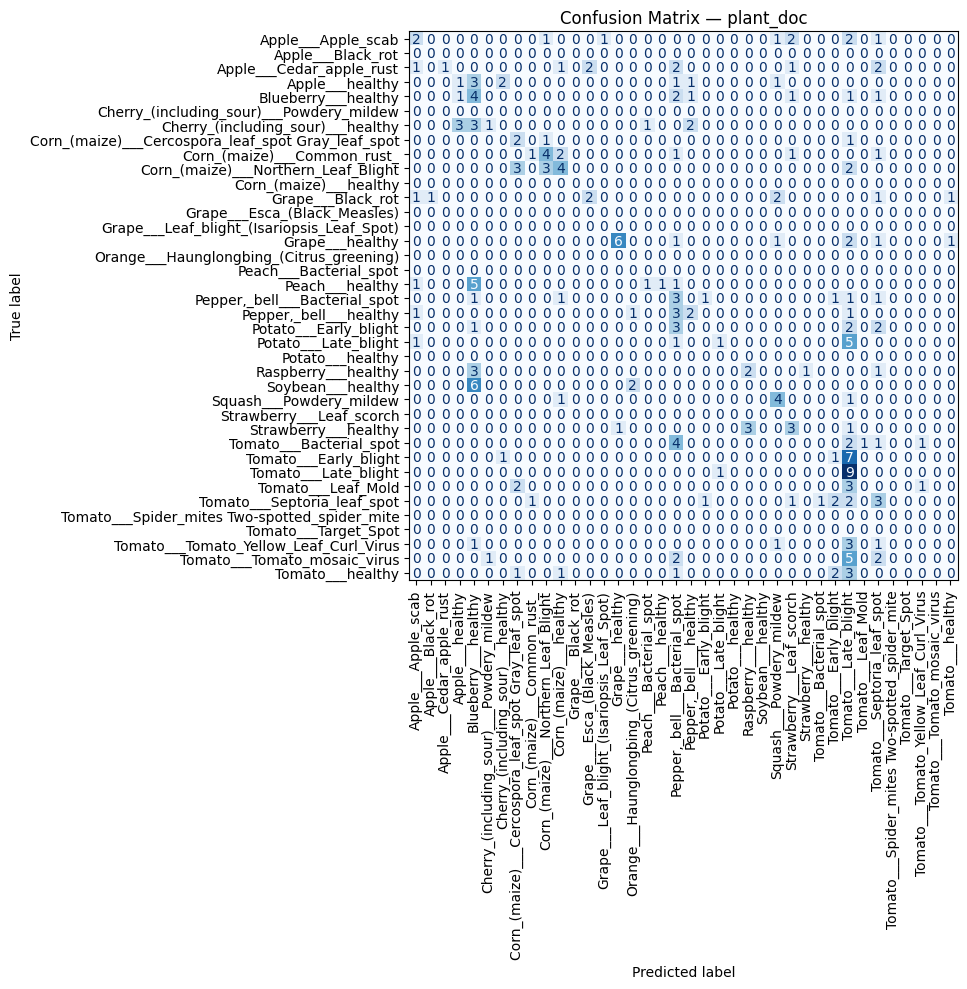

In [ ]:
name = "plant_doc"
loader = test_loaders[name]

labels, preds = get_preds_labels(alexnet, loader, device, loader.dataset.classes)
plot_confusion_matrix_full(name, labels, preds, global_classes)

Accuracy: 10.69% (185/1730)


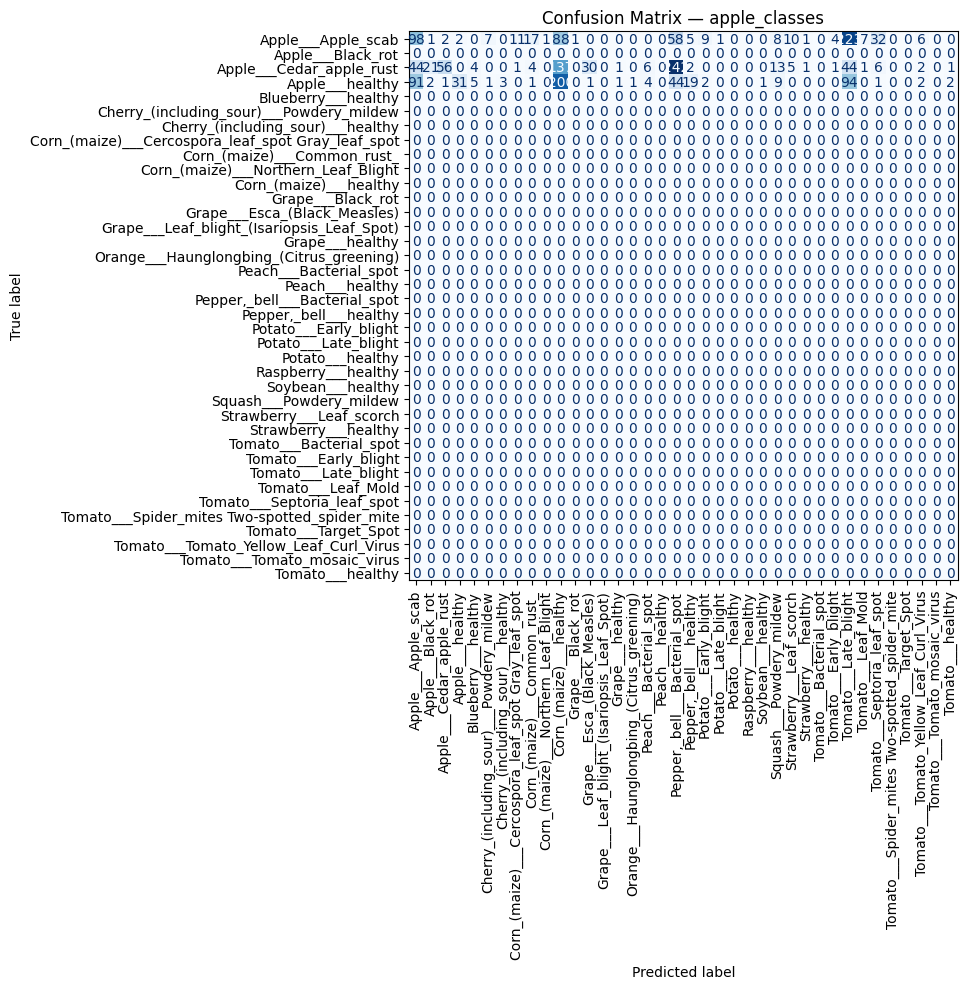

In [ ]:
name = "apple_classes"
loader = test_loaders[name]


labels, preds = get_preds_labels(alexnet, loader, device, loader.dataset.classes)
plot_confusion_matrix_full(name, labels, preds, global_classes)

Accuracy: 29.17% (194/665)


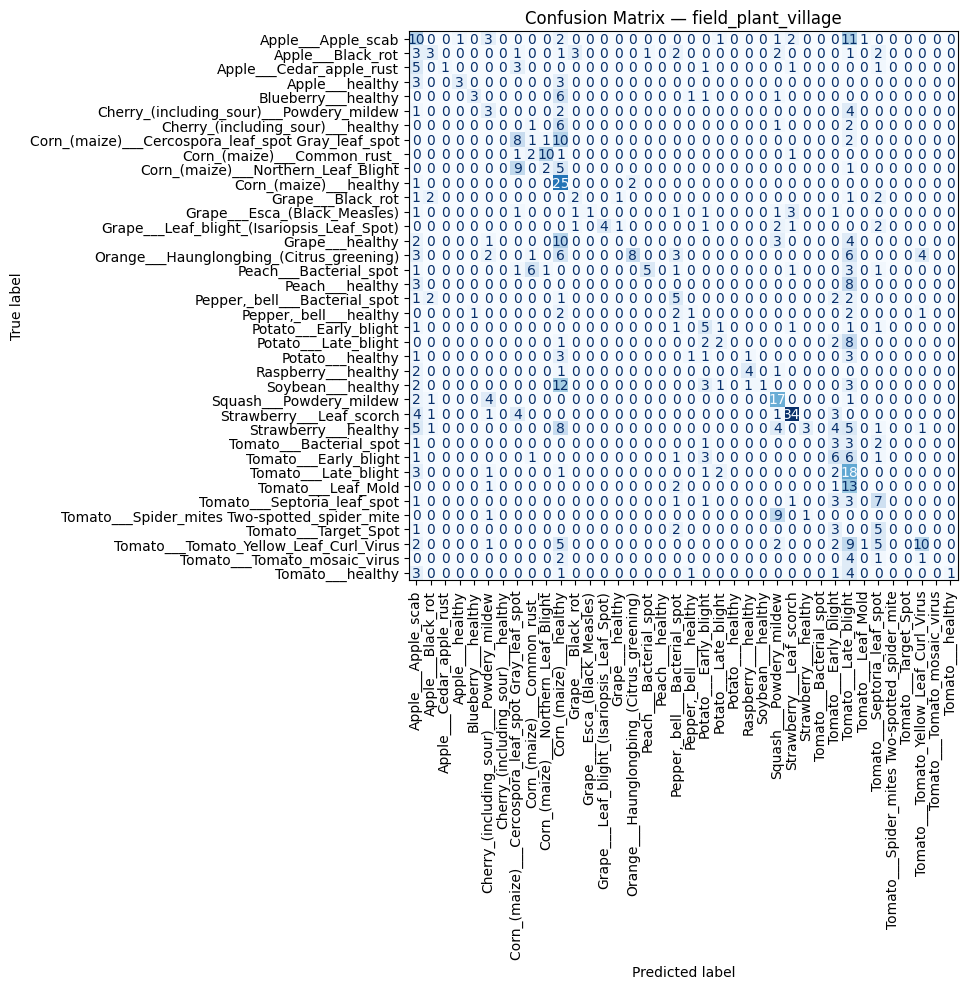

In [ ]:
name = "field_plant_village"
loader = test_loaders[name]


labels, preds = get_preds_labels(alexnet, loader, device, loader.dataset.classes)
plot_confusion_matrix_full(name, labels, preds, global_classes)

Accuracy: 15.13% (783/5176)


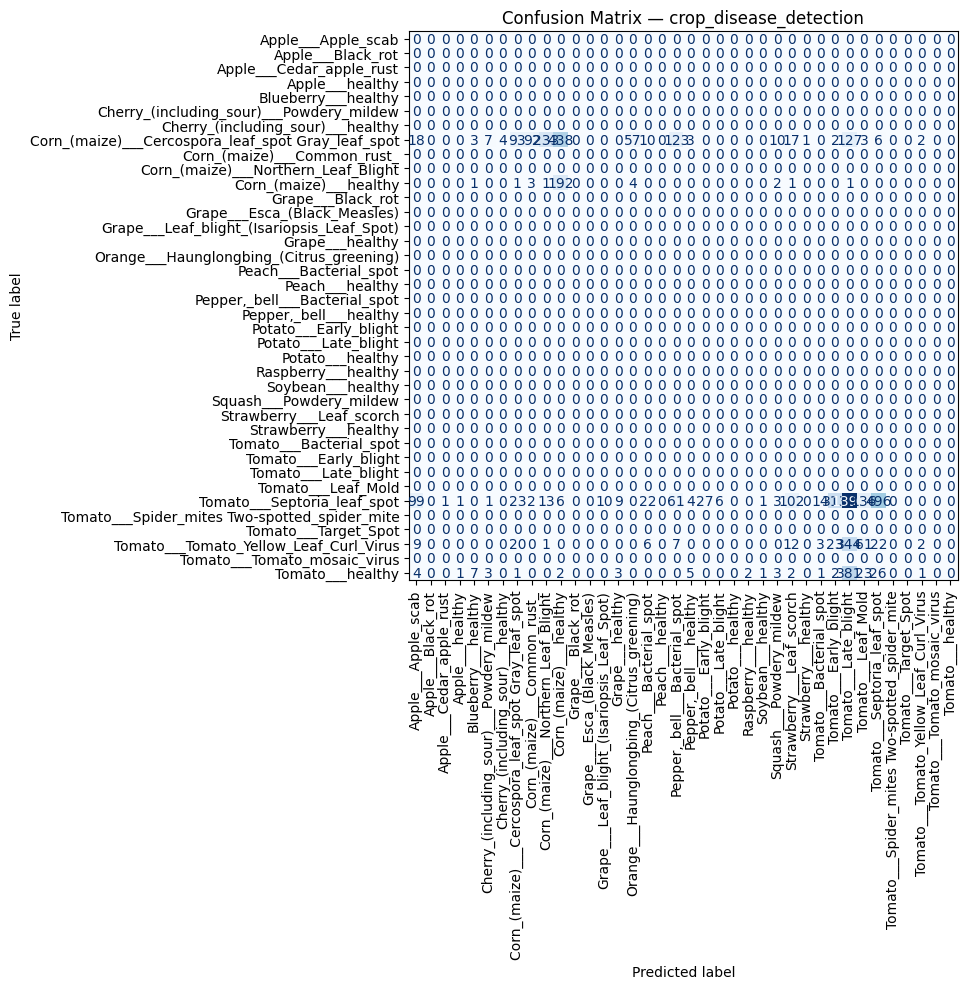

In [ ]:
name = "crop_disease_detection"
loader = test_loaders[name]

labels, preds = get_preds_labels(alexnet, loader, device, loader.dataset.classes)
plot_confusion_matrix_full(name, labels, preds, global_classes)

Accuracy: 97.77% (10693/10937)


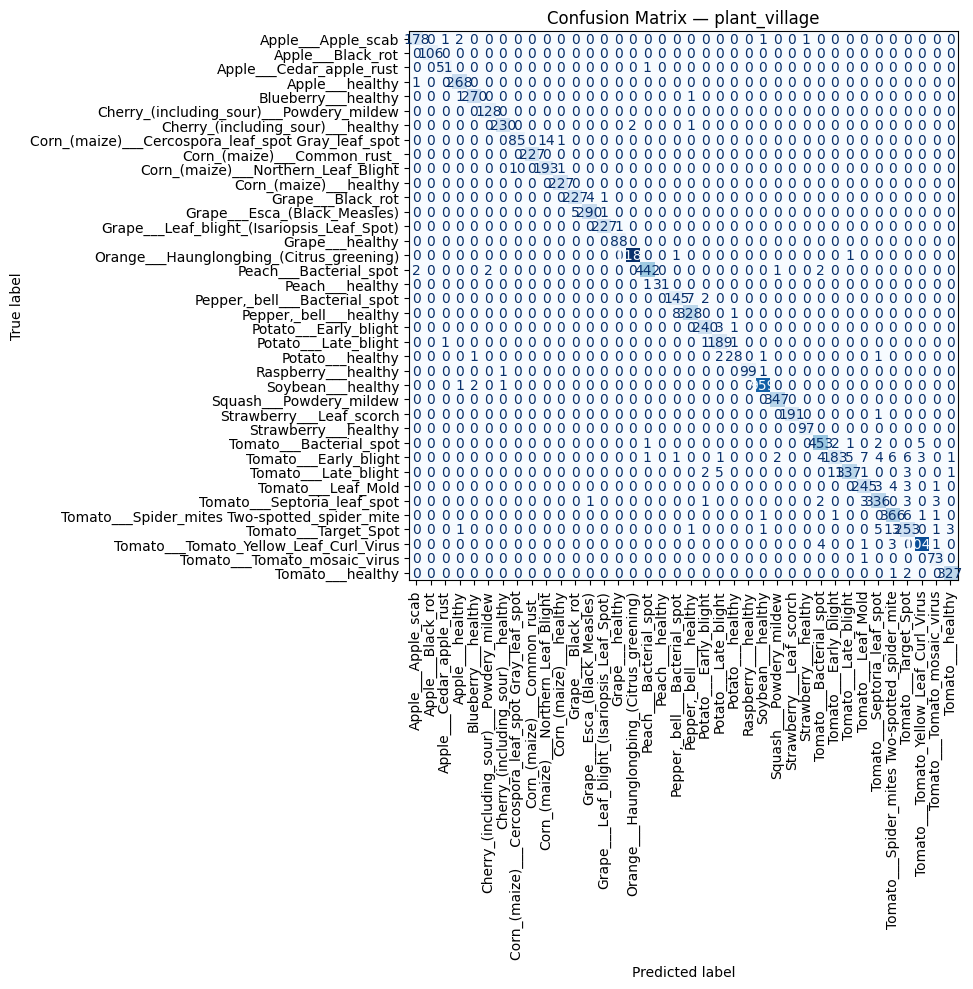

In [ ]:
name = "plant_village"
loader = test_loaders[name]

labels, preds = get_preds_labels(alexnet, loader, device, loader.dataset.classes)
plot_confusion_matrix_full(name, labels, preds, global_classes)

# Restricted accuracy and confusion matrices

In [ ]:
#restricted accuracy
def get_preds_labels_restricted(model, loader, device, dataset_classes):


    all_preds_global = []
    all_labels_global = []
    correct = 0
    total = 0

    # global to local class mapping: which global indices are present in this test set
    # dataset_classes is the list of local class names (for this loader)
    allowed_global_indices = []
    for local_idx, local_name in enumerate(dataset_classes):
        mapped_name = class_name_aliases.get(local_name, local_name)
        allowed_global_indices.append(class_name_to_full_idx[mapped_name])
    allowed_global_indices = list(allowed_global_indices) 

    model.eval()
    with torch.no_grad():
        for images, labels_local in loader:
            images = images.to(device)
            labels_local = labels_local.to(device)

            outputs = model(images)  

            # map local labels to global indices
            labels_mapped = []
            for l_tensor in labels_local.cpu():
                local_class_name = dataset_classes[l_tensor.item()]
                mapped_class_name = class_name_aliases.get(local_class_name,
                                                           local_class_name)
                try:
                    labels_mapped.append(class_name_to_full_idx[mapped_class_name])
                except KeyError:
                    raise KeyError(
                        f"Class name '{local_class_name}' "
                        f"(mapped to '{mapped_class_name}') not in global classes."
                    )
            labels_mapped = np.array(labels_mapped)

            # restricted accuracy: argmax only over test classes
            # select logits for the allowed global indices
            outputs_restricted = outputs[:, allowed_global_indices]
            _, preds_restricted_local = torch.max(outputs_restricted, 1)
            # map back to global indices
            preds_restricted_global = np.array(
                [allowed_global_indices[i] for i in preds_restricted_local.cpu().numpy()]
            )

            # update restricted accuracy
            correct += int((preds_restricted_global == labels_mapped).sum())
            total   += labels_mapped.size

            # store for confusion matrix (global space)
            all_labels_global.extend(labels_mapped.tolist())
            all_preds_global.extend(preds_restricted_global.tolist())

    acc_restricted = 100.0 * correct / total
    print(f"Restricted-class accuracy: {acc_restricted:.2f}% ({correct}/{total})")

    return all_labels_global, all_preds_global, acc_restricted


def plot_confusion_matrix_restricted(name, labels, preds, full_class_list):

    # Find all unique class indices present in either true or predicted labels
    used_classes = sorted(list(set(labels) | set(preds)))
    # Map indices to names for axis labeling
    display_names = [full_class_list[i] for i in used_classes]
    # Build restricted confusion matrix
    cm = confusion_matrix(labels, preds, labels=used_classes)
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_names)
    disp.plot(ax=ax, cmap="Blues", xticks_rotation=90, colorbar=False)
    plt.title(f"Restricted Confusion Matrix — {name}")
    plt.tight_layout()
    plt.show()

Restricted-class accuracy: 22.03% (52/236)
plant_doc: restricted accuracy = 22.03%


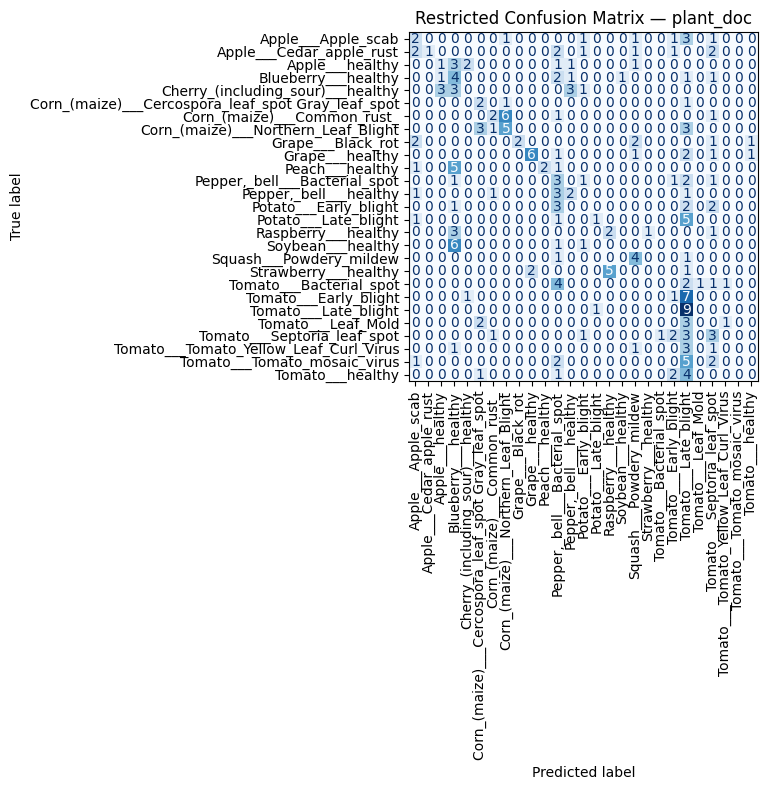

Restricted-class accuracy: 57.69% (2986/5176)
crop_disease_detection: restricted accuracy = 57.69%


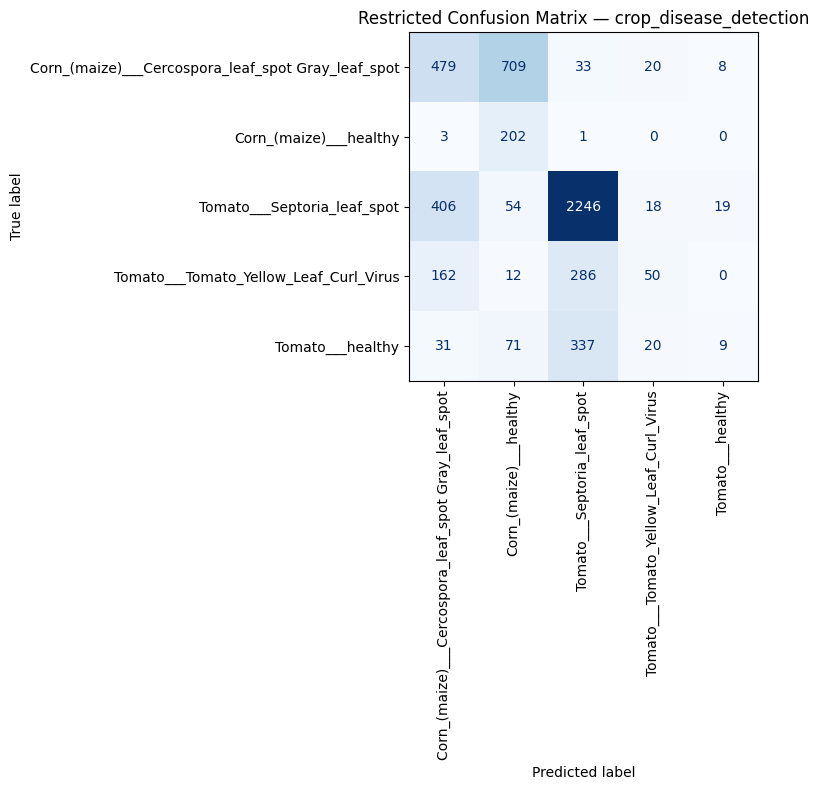

Restricted-class accuracy: 53.99% (934/1730)
apple_classes: restricted accuracy = 53.99%


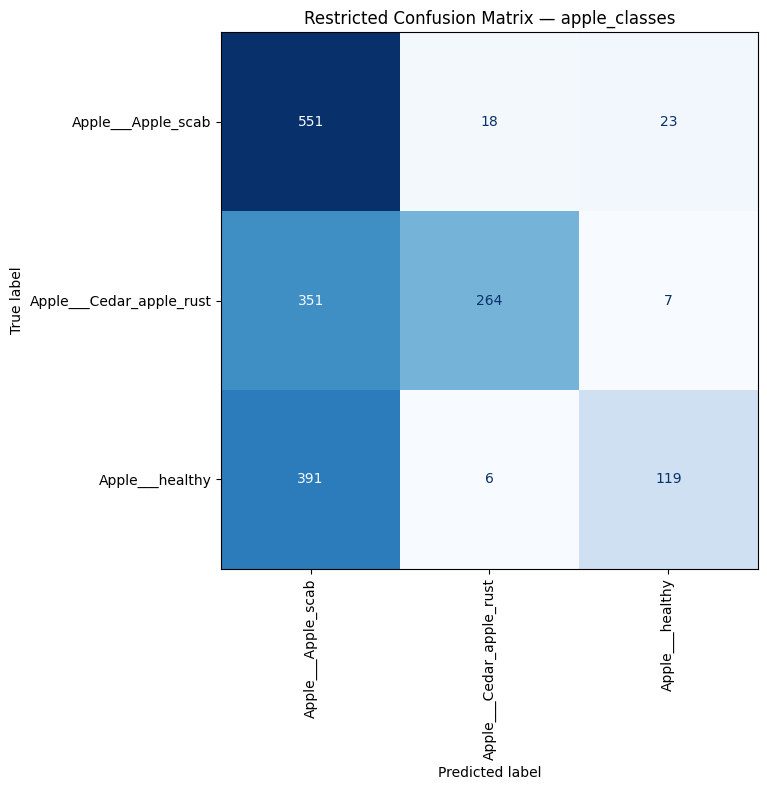

In [ ]:
selected_names = ["plant_doc", "crop_disease_detection", "apple_classes"]

for name in selected_names:
    if name not in test_loaders:
        print(f"{name} not found in test_loaders, skipping.")
        continue

    loader = test_loaders[name]
    dataset_classes = loader.dataset.classes  # local class names for this test set

    # Get globally-mapped labels/preds and restricted accuracy
    labels_g, preds_g, acc = get_preds_labels_restricted(
        alexnet, loader, device, dataset_classes
    )

    print(f"{name}: restricted accuracy = {acc:.2f}%")


    plot_confusion_matrix_restricted(name, labels_g, preds_g, global_classes)